In [2]:
'''
이번 챕터에서는 캐글에서 제공하는 정상 메일과 스팸 메일이 섞여져 있는 스팸 메일 데이터를 가지고, 
데이터에 대한 전처리를 진행하고 바닐라 RNN(Vanilla RNN)을 이용한 스팸 메일 분류기를 구현해보겠습니다.
'''

import numpy as np
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv',encoding='latin1')
#다운로드 받은 spam.csv 파일을 Pandas를 이용하여 data에 저장합니다. 총 샘플의 수를 확인해봅시다.

print('총 샘플의 수 :',len(data))   #총 샘플의 수 : 5572

총 샘플의 수 : 5572


In [3]:
#상의 5개만 출력해보자.
data[:5]

#상위 5개를 출력해보면, 이 데이터에는 총 5개의 열이 있는데, 여기서 Unnamed라는 이름의 3개의 열은 텍스트 분류를 할 때 불필요한 열  => 삭제 해야한다.
#v1열은 해당 메일이 스팸인지 아닌지를 나타내는 레이블에 해당되는 열입니다.
#ham은 정상 메일을 의미하고, spam은 스팸 메일을 의미합니다.
#v2열은 메일의 본문

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
#레이블과 메일 내용이 담긴 v1열과 v2열만 필요하므로, Unnamed: 2, Unnamed: 3, Unnamed: 4 열은 삭제합니다. 
#또한, v1열에 있는 ham과 spam 레이블을 각각 숫자 0과 1로 바꾸겠습니다. 그 후 다시 data에서 5개의 행만 출력해보겠습니다.

#3,4,5열 삭제 
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

#v1 ham, spam을 0, 1 로 변경 후 다시 상위 5개 출력
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#데이터 전반적인 정보를 확인해보자.
#data.info()

'''
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object   => 즉, 총 5,572개의 샘플이 존재
 '''

#null값 같은 샘플 있는지 확인해보자.
data.isnull().values.any()        # false => Null값이 없다. 즉 다 내용이 있다. 

#중복값이 있는지 알아보자.
data['v2'].nunique(), data['v1'].nunique()    #(5169, 2)
#=> 총 5,572개의 샘플이 존재하는데 v2열에서 중복을 제거한 샘플의 개수가 5,169개라는 것은 403개의 중복 샘플이 존재한다는 의미
#=> v1열은 0 또는 1의 값만을 가지므로 2가 출력

#중복 샘플 제거
data.drop_duplicates(subset=['v2'], inplace=True)

#제거 확인
if len(data) == 5169:
    print("제거 완료")  #=> 제거 완료

제거 완료


   v1  count
0   0   4516
1   1    653


'\n   v1  count\n0   0   4516\n1   1    653 레이블 0은 총 4,516개가 존재하고 1은 653개가 존재. '

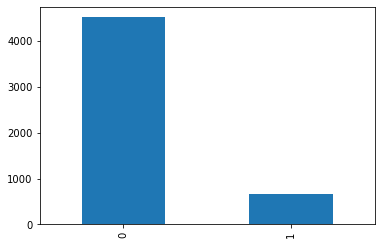

In [6]:
#시각화 및 데이터 분석
data['v1'].value_counts().plot(kind='bar');
#즉, 레이블이 대부분 0에 편중되어있는데, 이는 스팸 메일 데이터의 대부분의 메일이 정상 메일임을 의미. 


#수치로 확인해보겠습니다.
print(data.groupby('v1').size().reset_index(name='count'))
'''
   v1  count
0   0   4516
1   1    653 레이블 0은 총 4,516개가 존재하고 1은 653개가 존재. '''

In [7]:
#데이터 분리. => v2열을 X, v1열을 y로 저장
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


In [8]:
#인코딩 과정
tokenizer = Tokenizer()               #5169개의 행을 가진 X의 각 행에 토큰화를 수행. 
tokenizer.fit_on_texts(X_data)        #fit_on_texts() 메서드는 문자 데이터를 입력받아서 리스트의 형태로 변환
                                      #fit_on_texts는 입력한 텍스트로부터 단어 빈도수가 높은 순으로 낮은 정수 인덱스를 부여
                                      #정확히 앞서 설명한 정수 인코딩 작업 실행!


sequences = tokenizer.texts_to_sequences(X_data)  #단어를 숫자값, 인덱스로 변환하여 저장

print(sequences[:5])  #equences에는 X_data의 단어들이 각 단어에 맵핑되는 정수로 인코딩되어 저장

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


In [9]:
#tokenizer의 word_index 속성은 단어와 숫자의 키-값 쌍을 포함하는 딕셔너리를 반환.  => 빈도수 기준!!! 제일 많이 쓰인 순서
#X_data에 존재하는 모든 단어와 부여된 인덱스를 리턴
word_to_index = tokenizer.word_index
#print(word_to_index) 
'''
{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9
, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'call': 16, 
'have': 17, 'on': 18, '2': 19, 'that': 20, 'now': 21, 'are': 22, 'so': 23, 
'but': 24, 'not': 25, 'or': 26, 'do': 27, 'can': 28, 'at': 29, "i'm": 30, 'get': 31, 'be': 32,
'will': 33, 'if': 34, 'ur': 35, 'with': 36, 'just': 37, 'no': 38, 'we': 39, 'this': 40, 
'gt': 41, '4': 42, 'lt': 43, 'up': 44, 'when': 45, 'ok': 46, 'free': 47, 'from': 48, 'how': 49, 
'go': 50, 'all': 51, 'out': 52, - 이하 생략}'''

print("word_to_index의 사이즈 : ", len(word_to_index))  #word_to_index의 사이즈 :  8920

word_to_index의 사이즈 :  8920


In [10]:
'''
각 단어에 대한 등장 빈도수는 tokenizer.word_counts.items()를 출력으로 확인 가능
이를 응용하여 빈도수가 낮은 단어들이 훈련 데이터에서 얼만큼의 비중을 차지하는지 확인 가능!
등장 빈도수가 1회 밖에 되지 않는 단어들이 전체 단어 집합에서 얼만큼의 비율을 차지하며, 
전체 훈련 데이터에서 등장 빈도로 얼만큼의 비율을 차지하는지 확인해보자.
'''
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면.(2개이하, 즉 1개면)
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

'''
등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501 의 결과.

등장 빈도가 threshold 값인 2회 미만. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 절반 이상을 차지한다.. 
하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 6%밖에 되지 않습니다. 
만약, 이러한 분석을 통해 등장 빈도가 지나치게 낮은 단어들은 자연어 처리에서 제외하고 싶다면 
케라스 토크나이저 선언 시에 단어 집합의 크기를 제한할 수 있었다는 사실을 기억합시다. 
(정수 인코딩 챕터 참고) 가령, 아래의 코드로 등장 빈도가 1회인 단어들을 제외할 수 있다.'''

#tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)로 할 수 있으나. 여기선 하지 않겠다.


등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


'\n등장 빈도가 1번 이하인 희귀 단어의 수: 4908\n단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368\n전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501 의 결과.\n\n등장 빈도가 threshold 값인 2회 미만. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 절반 이상을 차지한다.. \n하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 6%밖에 되지 않습니다. \n만약, 이러한 분석을 통해 등장 빈도가 지나치게 낮은 단어들은 자연어 처리에서 제외하고 싶다면 \n케라스 토크나이저 선언 시에 단어 집합의 크기를 제한할 수 있었다는 사실을 기억합시다. \n(정수 인코딩 챕터 참고) 가령, 아래의 코드로 등장 빈도가 1회인 단어들을 제외할 수 있다.'

In [11]:

#단어 집합의 크기를 vocab_size에 저장. 주의할 점은 패딩을 위한 토큰인 0번 단어를 고려하며 +1을 해서 저장해야햔다..!! 
#(패딩을 하면 0번부터 하는데 실제로는 그것보다 1개 많은 것이므로!!)
vocab_size = len(word_to_index) + 1  
print('단어 집합의 크기: {}'.format((vocab_size)))         #단어 집합의 크기 : 8921

n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)                  #4135
print('테스트 데이터의 개수:',n_of_test)                  #1034


'''주의!
전체 메일의 개수는 5,169개입니다. 
이제 전체 메일 데이터에서 일부는 테스트 데이터로 분리해야한다.. 
전체 데이터의 80%를 훈련용 데이터로, 20%를 테스트 데이터로 사용하려고 한다.. 
숫자를 계산해보았더니 훈련 데이터는 4,135개, 테스트 데이터는 1,034개를 쓰도록 하자. 
아직은 단순히 숫자를 계산만해본 것이고, 실제로 데이터를 나누지는 않았다!!.'''

단어 집합의 크기: 8921
훈련 데이터의 개수 : 4135
테스트 데이터의 개수: 1034


메일의 최대 길이 : 189
메일의 평균 길이 : 15.610370


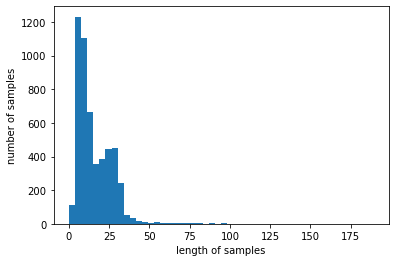

훈련 데이터의 크기(shape):  (5169, 189)


In [13]:
#직관적으로 변수를 기억하기위해 X_data에 대해서 정수 인코딩 된 결과인 sequences를 X_data로 변경 
#전체 데이터에서 가장 길이가 긴 메일과 전체 메일 데이터의 길이 분포를 알아보자

X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))           #메일의 최대 길이 : 189
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))   #메일의 평균 길이 : 15.610370
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')            
plt.ylabel('number of samples')
plt.show()

#전체 데이터의 길이 분포는 대체적으로 약 50이하의 길이

#전체 데이터셋의 길이는 max_len
#이는 5,169개의 X_data의 길이를 전부 189로. 189보다 길이가 짧은 메일 샘플은 전부 숫자 0이 패딩되어 189의 길이로 변환
max_len = 189

data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)  

In [14]:
#드디어 데이터 분리!!!
X_test = data[n_of_train:] #X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1034개의 데이터만 저장
X_train = data[:n_of_train] #X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4135개의 데이터만 저장

Epoch 1/4
52/52 [==============================] - 8s 120ms/step - loss: 0.4189 - acc: 0.8542 - val_loss: 0.2059 - val_acc: 0.9541
Epoch 2/4
52/52 [==============================] - 6s 113ms/step - loss: 0.1166 - acc: 0.9769 - val_loss: 0.0823 - val_acc: 0.9770
Epoch 3/4
52/52 [==============================] - 6s 110ms/step - loss: 0.0569 - acc: 0.9864 - val_loss: 0.0590 - val_acc: 0.9831
Epoch 4/4
33/33 [==============================] - 1s 20ms/step - loss: 0.1467 - acc: 0.9487

 테스트 정확도: 0.9487


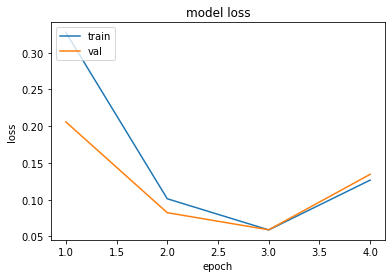

In [15]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()